# 1. 线性回归概念

线性回归模型：

$$
    y = w_1x_1+w_2x_2+...+w_nx_n+b
$$

其中，$n$为影响因素的个数，比如：房价预测问题，影响因素有地段、日期、面积，此时$x_1$表示地段、$x_2$表示日期、$x_3$表示面积

损失函数：

$$
    loss = \frac{1}{2n} \sum{(y_i - y)^2}
$$

通常的均方误差损失函数只要$\frac{1}{n}$即可，这里多除个2是为了求导的方便

对损失函数求导：

![image-20240426173613646](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20240426173613646.png)

这里的`X`是一个`m×n`矩阵，列数表示影响因素的个数，行数表示数据的条数。比如：房价预测考虑地段、面积、日期三个因素，同时有100条数据，此时`X`就是一个`100×3`的矩阵。由于引入偏置`b`，所以要在每一条数据最后加个`1`。

`w`是一个`n`维列向量。

`X·w`的结果是一个`m`维列向量，对这个列向量做内积并取平均，即可得到MSE。

# 2. 从零实现线性回归

In [205]:
import torch
import matplotlib.pyplot as plt
import random

## 2.1 生成人造数据集

In [206]:
def synthetic_data(w, b, num_example):
    # 随机生成X，用X计算得到标签y，y = Xw + b + 噪声
    # 噪声的目的是：给原本的X和y之间绝对的线性关系中添加非线性因素
    X = torch.normal(0, 1, (num_example, len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0, 0.01, y.shape)

    return X, y.reshape((-1,1))

w = torch.tensor([2.0,-3.4])    # 这里w的元素必须是float，即要写成小数，[2,-3]就不行，矩阵乘法不支持float和long矩阵相乘
b = 4.2
features, labels = synthetic_data(w, b, 1000)

features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

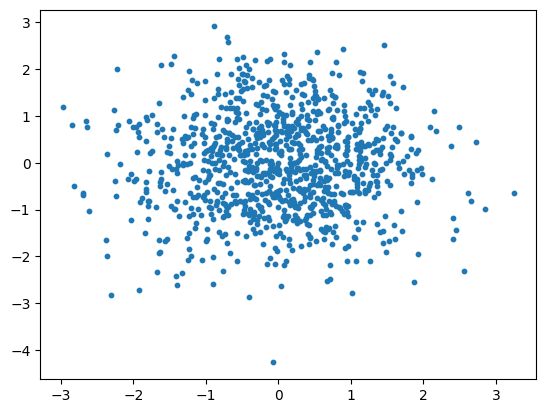

In [207]:
# 查看特征的分布
plt.scatter(x = features[:,0], y = features[:,1], s=10) # s为点的尺寸

## 2.2 生成batch

In [208]:
def data_iter(batch_size, features, labels):
    num_features = len(features)            # 特征的数量
    indices = list(range(num_features))     # 特征的下标数组

    random.shuffle(indices)                 # 取每一条特征的下标，并打乱顺序

    for i in range(0, num_features, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_features)])  # 从乱序的下标数组中取batch_size个，如果不足，则取完为止
        yield features[batch_indices], labels[batch_indices]                        # 生成一个iter

batch_size = 100
for X,y in data_iter(batch_size, features, labels):
    print(X.shape, y.shape)

torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100, 1])


## 2.3 初始化模型参数

In [209]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 2.4 定义模型

In [210]:
def linear_regression(X, w, b):
    return torch.matmul(X, w) + b

## 2.5 定义损失函数

In [211]:
def squared_loss(y, label):
    return torch.mean((y - label.reshape(y.shape))**2) / 2

## 2.6 定义优化算法

In [212]:
def sgd(params, lr, batch_size):
    with torch.no_grad():       # 在更新参数时，不需要计算梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

1. 这里为什么要除以batch_size？ 因为用batch训练时，比如将100个数据作为一个batch，计算出来的梯度是这100个数据梯度的总和。
2. 最后为什么要`param.grad.zero_()`？ 因为在计算时，参数的梯度会保存到grad里，同时第二次计算的会累加到之前的。

## 2.7 开始训练

In [213]:
lr = 1
num_epochs = 20
net = linear_regression
loss = squared_loss

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, features, labels):
        l = loss(net(x, w, b), y)
        l.sum().backward()          # 一个batch的所有损失求和，反向传播求梯度
        sgd([w, b], lr, batch_size)
    with torch.no_grad():           # 一个epoch结束，计算所有数据的损失均值
        train_l = loss(net(features, w, b), labels)
        print(f'epoch = {epoch + 1}, loss = {float(train_l.mean())}')

epoch = 1, loss = 13.967720031738281
epoch = 2, loss = 11.33918571472168
epoch = 3, loss = 9.20586109161377
epoch = 4, loss = 7.474114418029785
epoch = 5, loss = 6.068473815917969
epoch = 6, loss = 4.927373886108398
epoch = 7, loss = 4.001051425933838
epoch = 8, loss = 3.249041795730591
epoch = 9, loss = 2.6384196281433105
epoch = 10, loss = 2.142712354660034
epoch = 11, loss = 1.7401831150054932
epoch = 12, loss = 1.4133270978927612
epoch = 13, loss = 1.147930383682251
epoch = 14, loss = 0.9324186444282532
epoch = 15, loss = 0.7573977112770081
epoch = 16, loss = 0.6152527928352356
epoch = 17, loss = 0.4998056888580322
epoch = 18, loss = 0.40604478120803833
epoch = 19, loss = 0.32988765835762024
epoch = 20, loss = 0.2680289149284363


# 3. 线性回归的Pytorch实现

## 3.1 获取并生成数据集

In [1]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

w = torch.tensor([2, -3.4])
b = 4.2
features, labels = d2l.synthetic_data(w, b, 1000)

print("[Features and Labels shape]:\t", features.shape, labels.shape)

#
#   功能：对数据集划分batch，每个batch做成一个迭代器 
# #
def load_data(data_arrays, batch_size, is_trian = True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_trian)   # 如果该数据集用于训练，就需要打乱以增加模型的泛化能力及防止过拟合

batch_size = 10
data_iter = iter(load_data((features, labels), batch_size))   # 获取迭代器对象

# print('[data_iter example]:\n', next(data_iter))  # data_iter的一个迭代元素为一个[10个数据，10个标签]的list

<class 'torch.Tensor'>
[Features and Labels shape]:	 torch.Size([1000, 2]) torch.Size([1000, 1])


- `TensorDateset`：将多个张量（输入数据和标签）组合成一个Dataset对象，使该对象被`DataLoader`使用，用于批处理和迭代。
- `TensorDataset(*data_arrays)`：
  - `data_arrays`是一个元组，即`(features, labels)`，对元组使用`*`运算符意为依次取元组中的元素作为函数的参数，所以也可以写为`TensorDataset(features, labels)`
  - 该函数的形参要求：各个张量的第一维（样本数）必须相同
- `DataLoader`：将一个`Dataset`对象按照`batch_size`、`shuffle`生成一个**可迭代对象**

## 3.2 定义网络模型

In [215]:
from torch import nn

# torch是包，nn是torch的子包，网络层（如：Linear）是一个py文件
net = nn.Sequential(nn.Linear(2, 1))    # linear全连接层（输入为2，输出为1），sequential层序列

## 3.3 初始化模型参数

In [216]:
net[0].weight.data.normal_(0, 0.01) # 用正态分布填充权重
net[0].bias.data.fill_(0)           # 用0填充偏置项

tensor([0.])

## 3.4 损失函数

In [217]:
loss = nn.MSELoss() # 实例化损失函数

- `nn.MSELoss`是一个类

## 3.5 优化器

In [218]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

## 3.6 开始训练

In [219]:
# 设置超参数
epochs =  10

for epoch in range(epochs):
    data_iter = iter(load_data((features, labels), batch_size)) # 在每个epoch之前重新加载
    for x, y in data_iter:
        l = loss(net(x), y)
        trainer.zero_grad() # 每次反向传播计算梯度之前，清空保存的梯度
        l.backward()
        trainer.step()      # 更新参数
    # 一轮参数更新完毕，用该参数输出features和labels的loss
    l = loss(net(features), labels)
    print('epoch:', epoch, ",loss:", f"{l:f}")

epoch: 0 ,loss: 0.000195
epoch: 1 ,loss: 0.000107
epoch: 2 ,loss: 0.000106
epoch: 3 ,loss: 0.000106
epoch: 4 ,loss: 0.000106
epoch: 5 ,loss: 0.000108
epoch: 6 ,loss: 0.000106
epoch: 7 ,loss: 0.000105
epoch: 8 ,loss: 0.000107
epoch: 9 ,loss: 0.000106


- `l = loss(net(x), y)`：`loss`是一个对象，一个对象为什么能像函数一样使用呢？
  - 因为该对象具有`__call__`方法，可以像函数一样被调用，接收两个参数：
    - 模型的输出
    - 标签
- `data_iter`为`DataLoader`对象，在循环时自动迭代，但如果迭代完成，下一次想要重新迭代，需要重新加载